# Step 1: Load the Datasets


In [58]:
import pandas as pd
import gzip
import json

# Function to load a single dataset
def load_dataset(file_name):
    with gzip.open(file_name, 'r') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

# List of dataset files
files = [
    'reviews_Patio_Lawn_and_Garden_5.json.gz',
    'reviews_Tools_and_Home_Improvement_5.json.gz',
    'reviews_Office_Products_5.json.gz'
]

# Load and concatenate the datasets
df_list = [load_dataset(file) for file in files]
df = pd.concat(df_list, ignore_index=True)

# Display the shape and the first few rows of the combined dataframe
print(df.shape)
print(df.head())


(201006, 9)
       reviewerID        asin                            reviewerName helpful  \
0  A1JZFGZEZVWQPY  B00002N674  Carter H "1amazonreviewer@gmail . com"  [4, 4]   
1  A32JCI4AK2JTTG  B00002N674               Darryl Bennett "Fuzzy342"  [0, 0]   
2  A3N0P5AAMP6XD2  B00002N674                                     H B  [2, 3]   
3   A2QK7UNJ857YG  B00002N674                                   Jason  [0, 0]   
4   AS0CYBAN6EM06  B00002N674                                   jimmy  [1, 1]   

                                          reviewText  overall  \
0  Good USA company that stands behind their prod...      4.0   
1  This is a high quality 8 ply hose. I have had ...      5.0   
2  It's probably one of the best hoses I've ever ...      4.0   
3  I probably should have bought something a bit ...      5.0   
4  I bought three of these 5/8-inch Flexogen hose...      5.0   

                                             summary  unixReviewTime  \
0                                     

# Step 2: Clean the Text Data

In [59]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download stopwords and wordnet data
nltk.download('stopwords')
nltk.download('wordnet')

# Function to clean text data
def clean_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W+|\d+', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into one string separated by space 
    text = ' '.join(words)
    return text

# Apply the cleaning function to the reviewText column
df['cleaned_reviewText'] = df['reviewText'].apply(clean_text)

# Display the first few rows of the cleaned dataframe
print(df[['reviewText', 'cleaned_reviewText']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\52347\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\52347\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                          reviewText  \
0  Good USA company that stands behind their prod...   
1  This is a high quality 8 ply hose. I have had ...   
2  It's probably one of the best hoses I've ever ...   
3  I probably should have bought something a bit ...   
4  I bought three of these 5/8-inch Flexogen hose...   

                                  cleaned_reviewText  
0  good usa company stand behind product warranty...  
1  high quality ply hose good luck gilmour hose p...  
2  probably one best hose ever pro good enough fr...  
3  probably bought something bit flexible le rugg...  
4  bought three inch flexogen hose foot different...  


# Step 3: Create Word Embeddings
## a. Preparing the Data
First, prepare your text data for the embedding models. This involves tokenizing the cleaned text data into lists of words:

In [60]:
# Tokenize the cleaned reviews
df['tokenized_reviews'] = df['cleaned_reviewText'].apply(lambda x: x.split())

## b. Generating Embeddings
Use the gensim library to create both Word2Vec (with CBOW and SkipGram) and FastText embeddings. You'll need to decide on the dimensionality (100D, 200D, or 300D) based on your needs and computational constraints.

In [61]:
from gensim.models import Word2Vec, FastText

# Word2Vec CBOW model
model_w2v_cbow = Word2Vec(sentences=df['tokenized_reviews'], vector_size=100, window=5, min_count=2, sg=0)

# Word2Vec SkipGram model
model_w2v_sg = Word2Vec(sentences=df['tokenized_reviews'], vector_size=100, window=5, min_count=2, sg=1)

# FastText model
model_fasttext = FastText(sentences=df['tokenized_reviews'], vector_size=100, window=5, min_count=2, sg=1)

# Step 4: Average the Vectors for Each Review
To use the embeddings for sentiment analysis or other machine learning tasks, you might want to convert the variable-length reviews into fixed-size vectors. One common approach is to average the word vectors for each word in a review:

In [62]:
import numpy as np

# Function to average word vectors for a text
def average_vectors(model, words):
    # Filter out words not in the model's vocabulary
    words = [word for word in words if word in model.wv.key_to_index]
    
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        return []

# Apply the function to create averaged vector columns for each model
df['avg_vector_w2v_cbow'] = df['tokenized_reviews'].apply(lambda x: average_vectors(model_w2v_cbow, x))
df['avg_vector_w2v_sg'] = df['tokenized_reviews'].apply(lambda x: average_vectors(model_w2v_sg, x))
df['avg_vector_fasttext'] = df['tokenized_reviews'].apply(lambda x: average_vectors(model_fasttext, x))

# Step 5: Preparing Data for EDA

First, ensure that your DataFrame df only contains rows where the average vectors have been successfully computed. This might require filtering out any rows where the average vector is an empty list.

In [63]:
# Filter out rows with empty average vectors
df_filtered = df[df['avg_vector_w2v_cbow'].map(len) > 0]

# Step 6: Dimensionality Reduction with PCA
Reduce the dimensions of the averaged vectors to two dimensions using PCA for a scatter plot visualization.

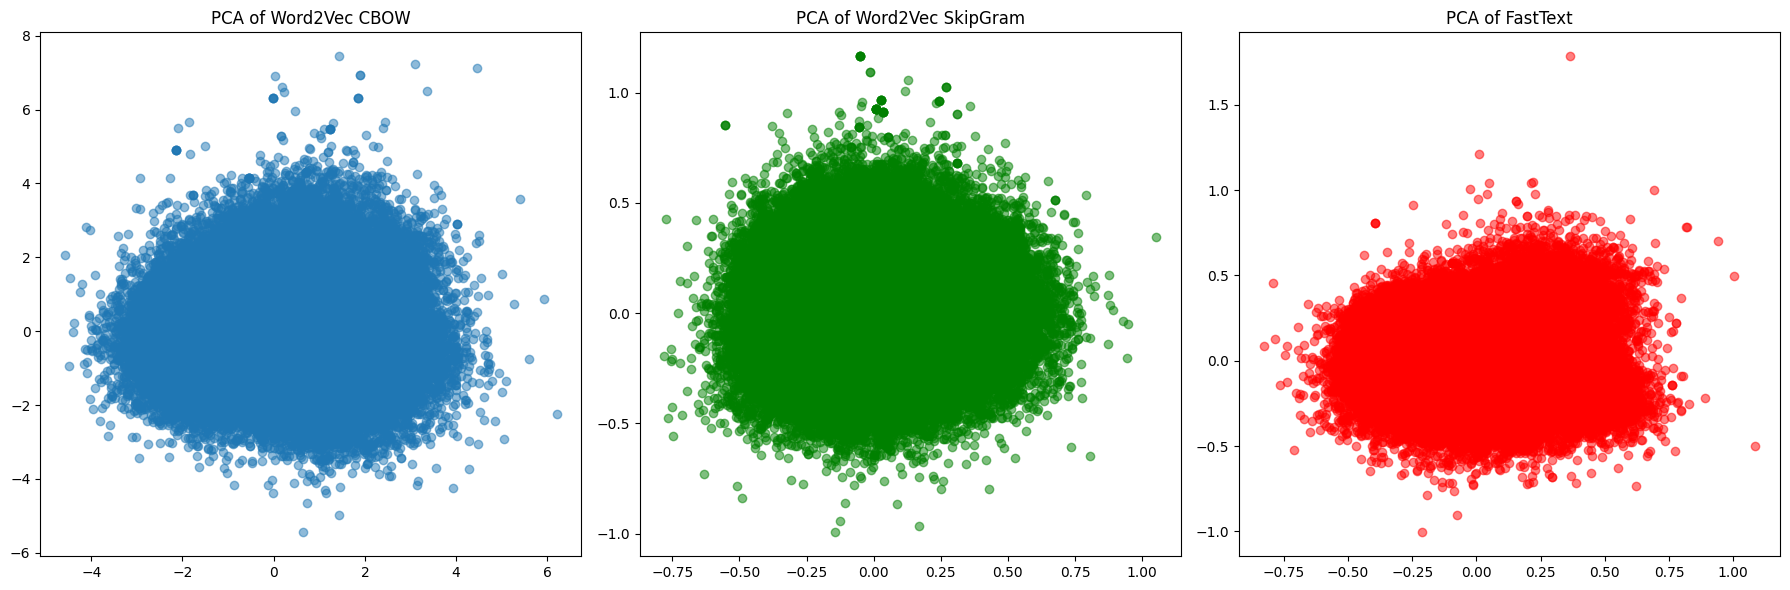

In [64]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize PCA model
pca = PCA(n_components=2)

# Prepare the data for PCA
vectors_w2v_cbow = list(df_filtered['avg_vector_w2v_cbow'])
vectors_w2v_sg = list(df_filtered['avg_vector_w2v_sg'])
vectors_fasttext = list(df_filtered['avg_vector_fasttext'])

# Apply PCA to each set of vectors
pca_w2v_cbow = pca.fit_transform(vectors_w2v_cbow)
pca_w2v_sg = pca.fit_transform(vectors_w2v_sg)
pca_fasttext = pca.fit_transform(vectors_fasttext)

# Plot the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(pca_w2v_cbow[:, 0], pca_w2v_cbow[:, 1], alpha=0.5)
plt.title('PCA of Word2Vec CBOW')

plt.subplot(1, 3, 2)
plt.scatter(pca_w2v_sg[:, 0], pca_w2v_sg[:, 1], alpha=0.5, color='green')
plt.title('PCA of Word2Vec SkipGram')

plt.subplot(1, 3, 3)
plt.scatter(pca_fasttext[:, 0], pca_fasttext[:, 1], alpha=0.5, color='red')
plt.title('PCA of FastText')

plt.tight_layout()
plt.show()



# Step 7: Similarity Metrics
Compute cosine similarity between the averaged vectors from the different models. This step involves comparing each review's vector from one model to its counterpart in the other models to quantify their similarity.

In [65]:
from scipy.spatial.distance import cosine

# Example function to compute average cosine similarity between two sets of vectors
def avg_cosine_similarity(vectors1, vectors2):
    similarities = [1 - cosine(vec1, vec2) for vec1, vec2 in zip(vectors1, vectors2) if len(vec1) > 0 and len(vec2) > 0]
    return np.mean(similarities)

# Compute average cosine similarity between models
avg_sim_cbow_sg = avg_cosine_similarity(vectors_w2v_cbow, vectors_w2v_sg)
avg_sim_cbow_ft = avg_cosine_similarity(vectors_w2v_cbow, vectors_fasttext)
avg_sim_sg_ft = avg_cosine_similarity(vectors_w2v_sg, vectors_fasttext)

print(f"Average Cosine Similarity between CBOW and SkipGram: {avg_sim_cbow_sg}")
print(f"Average Cosine Similarity between CBOW and FastText: {avg_sim_cbow_ft}")
print(f"Average Cosine Similarity between SkipGram and FastText: {avg_sim_sg_ft}")

Average Cosine Similarity between CBOW and SkipGram: 0.10700221830754657
Average Cosine Similarity between CBOW and FastText: -0.049382635879121166
Average Cosine Similarity between SkipGram and FastText: 0.12202998510033179


# Step 8: Convert Overall Rating to Binary Sentiment
First, convert the overall rating into a binary sentiment classification (positive or negative) and remove neutral reviews (rating of 3).

In [66]:
# Remove reviews with a rating of 3 (neutral)
df_filtered = df_filtered[df_filtered['overall'] != 3]

# Convert ratings into binary sentiment; 1&2 = Negative (0), 4&5 = Positive (1)
df_filtered['sentiment'] = df_filtered['overall'].apply(lambda x: 1 if x > 3 else 0)


# Step 9: Perform Dimension Reduction
Given the high-dimensional nature of text data, especially after vectorization, dimension reduction can help improve model performance and interpretability. We'll use PCA.

In [67]:
from sklearn.decomposition import PCA

# Assuming you've created a feature matrix X from your text data
# For demonstration, let's say we're using avg_vector_w2v_cbow as features
X = np.stack(df_filtered['avg_vector_w2v_cbow'])

# Initialize and fit PCA
pca = PCA(n_components=50)  # Reduce to 50 dimensions as an example
X_reduced = pca.fit_transform(X)

# Prepare the target variable
y = df_filtered['sentiment'].values


# Step 10: Train Classification Models - logistic
Before model training, split data into training and testing sets to evaluate the model's performance.
For this scenario, we'll focus on setting up a machine learning pipeline for a logistic regression model.

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Create a logistic regression model pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Define grid search parameters
param_grid = {
    'logisticregression__C': [0.1, 1.0, 10.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Calculate accuracy
logistic_regression_accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy}")


Logistic Regression Accuracy: 0.928937469334351


# Step 11: Train Classification Models - RNN
## Data Preparation
Before feeding the text data into a deep learning model, tokenize the text and pad the sequences to ensure they all have the same length.

In [69]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming df_filtered['cleaned_reviewText'] is your cleaned text column
texts = df_filtered['cleaned_reviewText'].astype(str)

# Tokenize text
tokenizer = Tokenizer(num_words=10000)  # Adjust `num_words` as necessary
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
data = pad_sequences(sequences, maxlen=200)  # Adjust `maxlen` as necessary

# Prepare labels
labels = df_filtered['sentiment'].values


## Define Model Architecture
define a simple RNN model using LSTM layers, suitable for sequence data like text.

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=200))  # Adjust these parameters as necessary
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Training
Split the data into training and validation sets, then train the model.

In [71]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train, batch_size=256, epochs=3, validation_data=(X_test, y_test))  # Adjust `batch_size` and `epochs` as necessary


Epoch 1/3
574/574 [==============================] - 952s 2s/step - loss: 0.1991 - accuracy: 0.9334 - val_loss: 0.1563 - val_accuracy: 0.9437
Epoch 2/3
574/574 [==============================] - 1028s 2s/step - loss: 0.1400 - accuracy: 0.9487 - val_loss: 0.1522 - val_accuracy: 0.9452
Epoch 3/3
574/574 [==============================] - 1013s 2s/step - loss: 0.1220 - accuracy: 0.9554 - val_loss: 0.1539 - val_accuracy: 0.9461


## Evaluation
Evaluate the model's performance on the test set.

In [72]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

1147/1147 [==============================] - 44s 38ms/step - loss: 0.1539 - accuracy: 0.9461
Test Accuracy: 0.9460829496383667


# Step 12: apply VADER and TextBlob on reviews

In [73]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Apply VADER to all reviews
df_filtered['vader_sentiment'] = df_filtered['reviewText'].apply(lambda review: sia.polarity_scores(str(review))['compound'])

# Apply TextBlob to all reviews
df_filtered['textblob_polarity'] = df_filtered['reviewText'].apply(lambda review: TextBlob(str(review)).sentiment.polarity)


print("Average VADER Sentiment Score:", df_filtered['vader_sentiment'].mean())
print("Average TextBlob Polarity Score:", df_filtered['textblob_polarity'].mean())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\52347\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Average VADER Sentiment Score: 0.6207492841878012
Average TextBlob Polarity Score: 0.21542061909330282


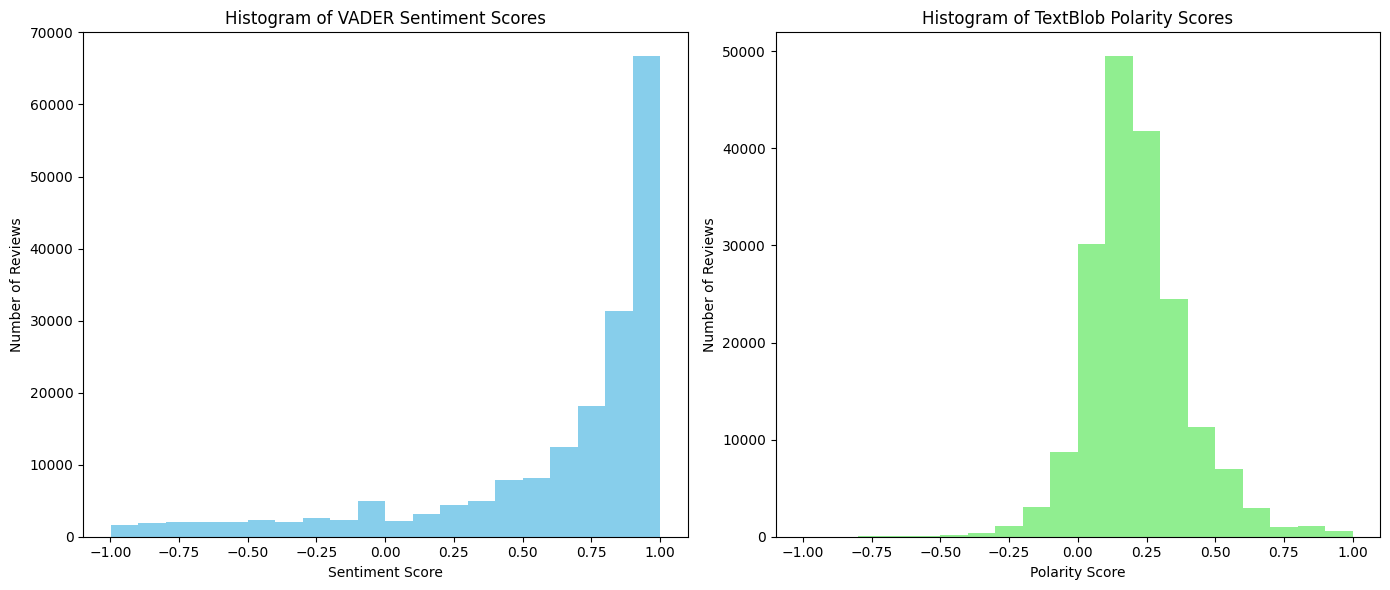

In [74]:
# Plot histograms of the sentiment scores
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df_filtered['vader_sentiment'], bins=20, color='skyblue')
plt.title('Histogram of VADER Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')

plt.subplot(1, 2, 2)
plt.hist(df_filtered['textblob_polarity'], bins=20, color='lightgreen')
plt.title('Histogram of TextBlob Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Number of Reviews')

plt.tight_layout()
plt.show()


# Step 13: Compare Machine Learning and Deep Learning Models
Comparing the performance metrics (such as accuracy) of the logistic regression and RNN models trained. 

In [75]:
# Compare accuracies
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy}")
print(f"RNN Model Accuracy: {accuracy}")

# Choose the model with the highest accuracy
if logistic_regression_accuracy > accuracy:
    print("Logistic Regression performs better.")
else:
    print("RNN Model performs better.")


Logistic Regression Accuracy: 0.928937469334351
RNN Model Accuracy: 0.9460829496383667
RNN Model performs better.


# Step 14: Analyze SA on the test data and describe the results. 
Calculate the main performance metrics for your test data predictions, use a confusion matrix provides a visual and numerical way to understand the performance of a classification model.

Accuracy: 0.9289
Precision: 0.9354
Recall: 0.9915
F1 Score: 0.9627


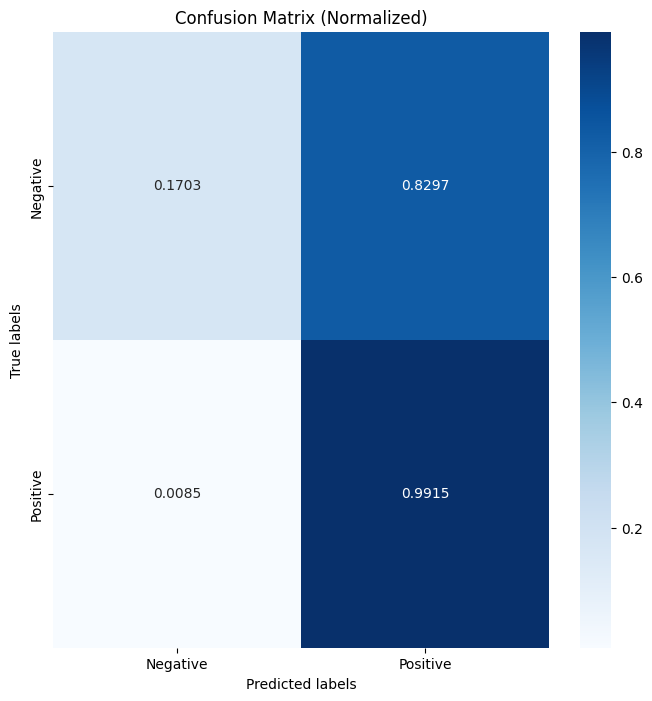

In [83]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming y_test contains true labels and y_pred contains predicted labels from your chosen model
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap="Blues", fmt=".4f",
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (Normalized)')
plt.show()


# Step 14 : Error Analysis
This method maps model predictions back to the original dataset to identify and analyze misclassifications, helping understand and improve the model's performance.
Look for patterns in the instances where the model went wrong. For example, filter out reviews where the model made False Positive (or False negative) errors and look for patterns. 

In [132]:
# Split the data while preserving indices
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, df_filtered.index, test_size=0.2, random_state=42
)

# After training the model and making predictions on X_test
# Map y_pred back to the original DataFrame
df_test_subset = df_filtered.loc[indices_test]
df_test_subset['predicted_sentiment'] = y_pred

# Now, analyze false positives and negatives
false_positives = df_test_subset[(df_test_subset['sentiment'] == 0) & (df_test_subset['predicted_sentiment'] == 1)]
false_negatives = df_test_subset[(df_test_subset['sentiment'] == 1) & (df_test_subset['predicted_sentiment'] == 0)]


prints a sample of five reviews that were incorrectly classified as positive, helping to identify patterns contributing to misclassifications by the model.

In [134]:
for review in false_positives['reviewText'].sample(5).values:
    print(review + "\n")

If this unit had an extra setting to allow for silent arming and disarming + a volume adjustment on the chime mode, it would be an acceptable device for indoor use. Returned to vendor...

Blades are hard to find and very expensive. The batteries don't hold a charge very long. I've had other Bosch battery powered tools and had the same experience. I won't consider them again.

Seventeen lumens sounded like a respectable amount of light. A lumen is a measure of light output in all directions. Another measure, lux, measures light output in a single direction. Since a flashlight, unlike a street light, concentrates light in one direction, a better measure would have been lux. I'll wager the lux measure for this light is low. The light is dim. At about 10 feet from a wall, it makes a weak, small, circular spot about 2 1/2 feet in diameter. In a darkened garage, objects at twenty feet away are marginally identifiable. The touted emergency checklist may be okay for cub scouts, but it's just f

compare the average length of false positives against the dataset to see if there's a noticeable difference.

In [135]:
false_positives['review_length'] = false_positives['reviewText'].apply(len)
avg_len_fp = false_positives['review_length'].mean()
avg_len_overall = df_test_subset['reviewText'].apply(len).mean()

print(f"Average Review Length - False Positives: {avg_len_fp}")
print(f"Average Review Length - Overall: {avg_len_overall}")


Average Review Length - False Positives: 806.950409659336
Average Review Length - Overall: 648.371722182849


C:\Users\52347\AppData\Local\Temp\ipykernel_32896\3939857103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positives['review_length'] = false_positives['reviewText'].apply(len)


This function extracts and counts the most frequent words from a collection of reviews, returning the top specified number of words.

In [140]:
from collections import Counter

def get_top_words(reviews, num_words=10):
    # Tokenize the reviews and flatten the list of words
    all_words = [word for review in reviews for word in review.split()]
    
    # Count the words
    word_counts = Counter(all_words)
    
    # Return the most common words
    return word_counts.most_common(num_words)
    

This function generates and displays a word cloud based on the input text data, allowing for visual analysis of the most frequent terms in the provided text.

In [ ]:
from wordcloud import WordCloud

# Function to generate and display word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

identifies the most common words in reviews that were incorrectly classified as positive, helping to uncover patterns in misclassifications.

Top words in False Positives: [('one', 1878), ('use', 1274), ('would', 1208), ('work', 1160), ('get', 1133), ('light', 1087), ('like', 1006), ('time', 951), ('product', 873), ('good', 773)]


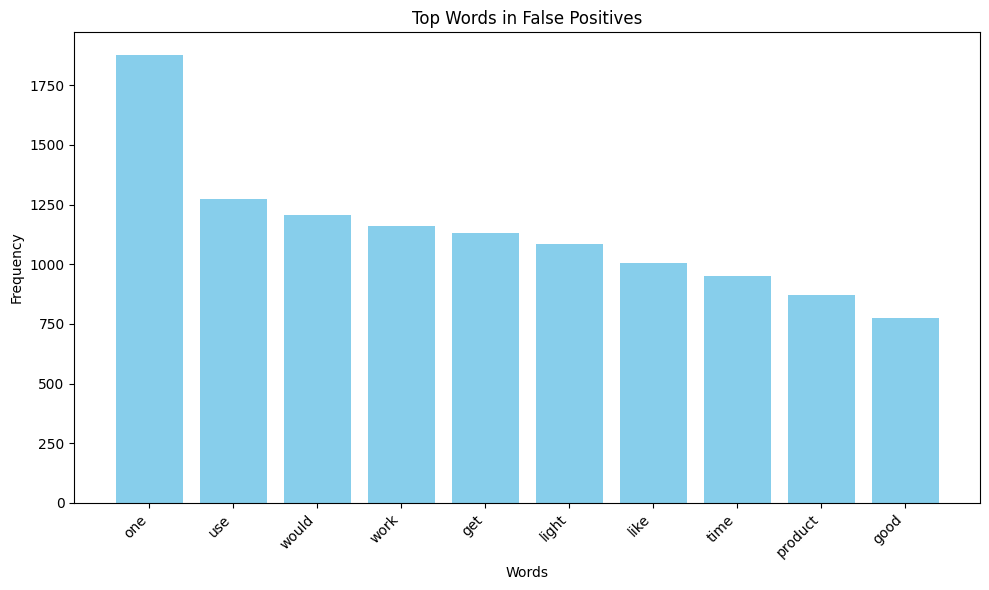

In [144]:
top_words_fp = get_top_words(false_positives['cleaned_reviewText'])
print("Top words in False Positives:", top_words_fp)

# Get the top words and their counts
top_words_fp = get_top_words(false_positives['cleaned_reviewText'])
words = [word[0] for word in top_words_fp]
counts = [word[1] for word in top_words_fp]

# Plot the top words
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top Words in False Positives')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

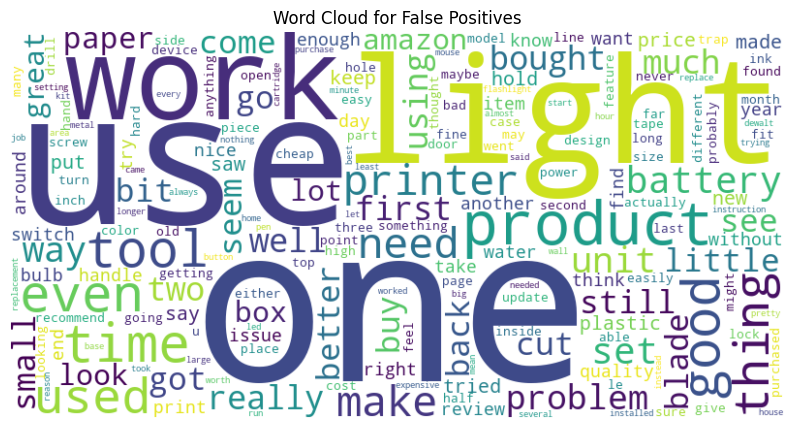

In [148]:
# Generate word cloud for false positives
false_positives_text = ' '.join(false_positives['cleaned_reviewText'])
generate_word_cloud(false_positives_text, 'Word Cloud for False Positives')

prints a sample of five reviews that were incorrectly classified as negative, aiding in understanding misclassifications by the model.

In [136]:
for review in false_negatives['reviewText'].sample(5).values:
    print(review + "\n")

I tried this out on a day when it was raining all day.  I don't know what &#34;Rainproof in 15 minutes&#34; mean on the canister, but it rained all day, I sprayed it on weeds in a crack because I couldn't wait for the next clear day, and the weeds turned brown.  I can't say how fast it worked since I sprayed it and didn't check again until the next morning, but they were all brown.  I don't know if I'll have to actually pull them out now or if they'll eventually die off but I don't want to get my hands dirty so I'm going to wait and see.

Had to call customer service when I first installed it just to getting working well.  No problems.  Takes a little getting used to.

Want to toss those awful chandelier bulbs? With these you can. One issue was that it takes a long time to recieve. These are out of China. took about 4 weeks to receive but worth the wait.

Get what you pay for.  It's a little bit on the thick side, and difficult to sharpen.  Guess when I get it sharp enough, it'll be ok

calculates and prints the average length of reviews that were incorrectly classified as negative (false negatives), providing insight into the length distribution of misclassified reviews.

In [138]:
false_negatives['review_length'] = false_negatives['reviewText'].apply(len)
avg_len_fn = false_negatives['review_length'].mean()

print(f"Average Review Length - False Negatives: {avg_len_fn}")


Average Review Length - False Negatives: 406.89930555555554


C:\Users\52347\AppData\Local\Temp\ipykernel_32896\372434069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_negatives['review_length'] = false_negatives['reviewText'].apply(len)


 retrieves the top words present in reviews that were incorrectly classified as negative (false negatives) and prints them. It provides insights into common words associated with misclassified negative reviews.

Top words in False Negatives: [('one', 166), ('would', 107), ('get', 94), ('work', 83), ('time', 71), ('light', 63), ('review', 55), ('mouse', 54), ('product', 52), ('first', 52)]


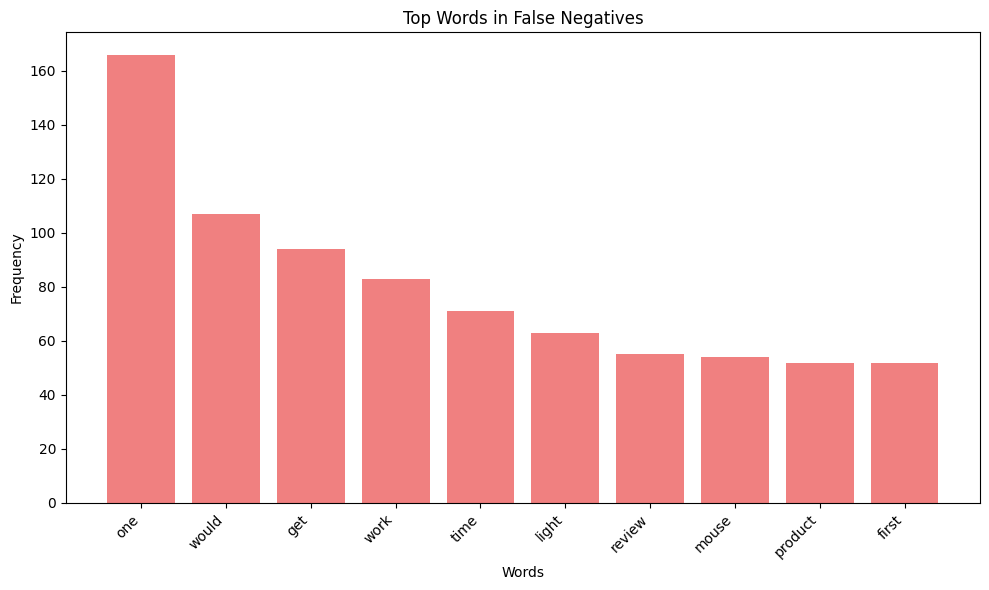

In [145]:
top_words_fn = get_top_words(false_negatives['cleaned_reviewText'])
print("Top words in False Negatives:", top_words_fn)

# Get the top words and their counts
top_words_fn = get_top_words(false_negatives['cleaned_reviewText'])
words = [word[0] for word in top_words_fn]
counts = [word[1] for word in top_words_fn]

# Plot the top words
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='lightcoral')
plt.title('Top Words in False Negatives')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

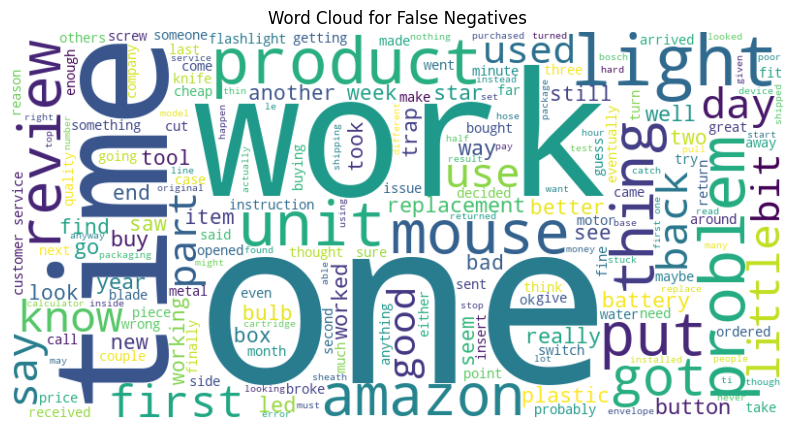

In [149]:
# Generate word cloud for false negatives
false_negatives_text = ' '.join(false_negatives['cleaned_reviewText'])
generate_word_cloud(false_negatives_text, 'Word Cloud for False Negatives')
